In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


### 스키마 키 공유 Case

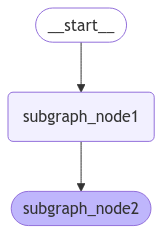

In [1]:
class ChildState(TypedDict):
    name: str
    family_name: str


def subgraph_node1(state: ChildState):
    return {"family_name": "Kim"}


def subgraph_node2(state: ChildState):
    return {"name": f'{state["name"]} {state["family_name"]}'}


subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node1)
subgraph_builder.add_node(subgraph_node2)
subgraph_builder.add_edge(START, "subgraph_node1")
subgraph_builder.add_edge("subgraph_node1", "subgraph_node2")
subgraph = subgraph_builder.compile()

display(Image(subgraph.get_graph(xray=True).draw_mermaid_png()))


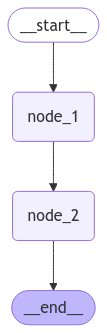

In [3]:
class ParentState(TypedDict):
    name: str
    company: str


def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


builder = StateGraph(ChildState)
builder.add_node(node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [4]:
for chunk in graph.stream({"name": "Joseph"}):
    print(chunk)

{'node_1': {'name': 'My name is Joseph'}}
{'node_2': {'name': 'My name is Joseph Kim', 'family_name': 'Kim'}}


In [6]:
for chunk in graph.stream({"name": "Joseph"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'name': 'My name is Joseph'}})
(('node_2:e2aac2f4-9bbe-3f15-4d7b-e3efcaac1b12',), {'subgraph_node1': {'family_name': 'Kim'}})
(('node_2:e2aac2f4-9bbe-3f15-4d7b-e3efcaac1b12',), {'subgraph_node2': {'name': 'My name is Joseph Kim'}})
((), {'node_2': {'name': 'My name is Joseph Kim', 'family_name': 'Kim'}})


### 스키마 키 공유 x Case

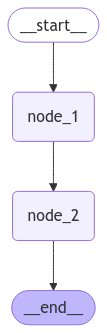

In [7]:
class ChildState(TypedDict):
    name: str


def subgraph_node_1(state: ChildState):
    return {"name": "Joseph " + state["name"]}


def subgraph_node_2(state: ChildState):
    return {"name": f'My name is {state["name"]}'}


subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


class ParentState(TypedDict):
    family_name: str
    full_name: str


def node_1(state: ParentState):
    return {"family_name": state["family_name"]}


def node_2(state: ParentState):
    response = subgraph.invoke({"name": state["family_name"]})
    return {"full_name": response["name"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [8]:
for chunk in graph.stream({"family_name": "Kim"}, subgraphs=True):
    print(chunk)


((), {'node_1': {'family_name': 'Kim'}})
(('node_2:dfe219ec-3278-dc6c-4de7-c8ca3f12d15c',), {'subgraph_node_1': {'name': 'Joseph Kim'}})
(('node_2:dfe219ec-3278-dc6c-4de7-c8ca3f12d15c',), {'subgraph_node_2': {'name': 'My name is Joseph Kim'}})
((), {'node_2': {'full_name': 'My name is Joseph Kim'}})


### 중복 상태 키 x

#### GrandChild

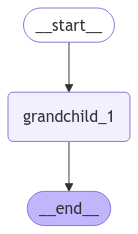

In [9]:
class GrandChildState(TypedDict):
    my_grandchild_key: str


def grandchild_1(state: GrandChildState) -> GrandChildState:
    return {"my_grandchild_key": f'([GrandChild] {state["my_grandchild_key"]})'}


grandchild = StateGraph(GrandChildState)
grandchild.add_node("grandchild_1", grandchild_1)
grandchild.add_edge(START, "grandchild_1")
grandchild.add_edge("grandchild_1", END)
grandchild_graph = grandchild.compile()

display(Image(grandchild_graph.get_graph(xray=True).draw_mermaid_png()))


In [10]:
for chunk in grandchild_graph.stream(
    {"my_grandchild_key": "Hi, Joseph!"}, subgraphs=True
):
    print(chunk)

((), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Joseph!)'}})


#### Child

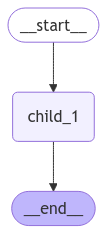

In [11]:
class ChildState(TypedDict):
    my_child_key: str


def call_grandchild_graph(state: ChildState) -> ChildState:
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": f'([Child] {grandchild_graph_output["my_grandchild_key"]})'}


child = StateGraph(ChildState)
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
child_graph = child.compile()

display(Image(child_graph.get_graph(xray=True).draw_mermaid_png()))


In [12]:
for chunk in child_graph.stream({"my_child_key": "Hi, Joseph!"}, subgraphs=True):
    print(chunk)

(('child_1:75ef6683-0251-01b9-a6f3-bd9c1123d165',), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Joseph!)'}})
((), {'child_1': {'my_child_key': '([Child] ([GrandChild] Hi, Joseph!))'}})


#### Parent

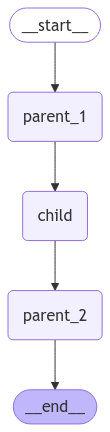

In [13]:
class ParentState(TypedDict):
    my_parent_key: str


def parent_1(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent1] {state["my_parent_key"]})'}


def parent_2(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent2] {state["my_parent_key"]})'}


def call_child_graph(state: ParentState) -> ParentState:
    child_graph_input = {"my_child_key": state["my_parent_key"]}
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_parent_key": child_graph_output["my_child_key"]}


parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)
parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)
parent_graph = parent.compile()

display(Image(parent_graph.get_graph(xray=True).draw_mermaid_png()))


In [14]:
for chunk in parent_graph.stream({"my_parent_key": "Hi, Joseph!"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_parent_key': '([Parent1] Hi, Joseph!)'}})
(('child:9930a6b8-74cc-9cc2-c81b-19bde829b030', 'child_1:00181041-2af4-e313-f9b5-f2320709ea8e'), {'grandchild_1': {'my_grandchild_key': '([GrandChild] ([Parent1] Hi, Joseph!))'}})
(('child:9930a6b8-74cc-9cc2-c81b-19bde829b030',), {'child_1': {'my_child_key': '([Child] ([GrandChild] ([Parent1] Hi, Joseph!)))'}})
((), {'child': {'my_parent_key': '([Child] ([GrandChild] ([Parent1] Hi, Joseph!)))'}})
((), {'parent_2': {'my_parent_key': '([Parent2] ([Child] ([GrandChild] ([Parent1] Hi, Joseph!))))'}})
